In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


Analysis of ResNet Training Results on ImageNet
===

In [2]:
import os
import sys
import random
import itertools
import time
import tempfile
import shutil
from contextlib import ExitStack

from PIL import Image
import numpy as np
import cupy as cp
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F
from chainer.datasets import mnist, fashion_mnist
from chainer import training
from chainer.training import extensions

from chainercv.links import PickableSequentialChain
from chainercv import transforms

from ada_loss.chainer_impl.ada_loss_scaled import AdaLossScaled
from ada_loss.chainer_impl.ada_loss import AdaLossChainer
from ada_loss.chainer_impl.ada_loss_recorder import AdaLossRecorder

import utils

## Load training results

We have trained ResNet-18 with `mixed16` in two different settings: no loss scaling and adaptive loss scaling (`scale_upper_bound=16`, `accum_upper_bound=1024`).

## New Result from Approx Range

This result is collected from a recent run.

```shell
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet18 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method approx_range
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet18 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method approx_range --update-per-n-iteration 1000
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet18 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method fixed --init-scale 128
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet18 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method fixed --init-scale 1

python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet50 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method approx_range
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet50 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method approx_range --update-per-n-iteration 1000
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet50 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method fixed --init-scale 128
python3 examples/adaptive_loss_scaling/imagenet/train_imagenet_multi.py -a resnet50 --dataset-dir /home/user/data/imagenet --dtype mixed16 --out /home/user/results --loss-scale-method fixed --init-scale 1
```

In [82]:
DIRS = {
    'ada_loss': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/ada_loss.20190809/',
    'ada_loss (F=1k)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/resnet18_ada_loss_freq_1000_16GPU.20190823/',
    'ada_loss (F=1k, SB=128)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/ada_loss.GPU_16_F_1000_SB_128.20190923',
    'no_loss_scale': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/no_loss_scale.20190823',
    'loss_scale_128': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/loss_scale_128.20190823',
    'dyn_intv_10': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/dyn_loss_scale.GPU_16_intv_10.20190905',
}

ada_loss: best validation accuracy=71.48
ada_loss (F=1k): best validation accuracy=71.29
ada_loss (F=1k, SB=128): best validation accuracy=71.44
no_loss_scale: best validation accuracy=71.24
loss_scale_128: best validation accuracy=71.39
dyn_intv_10: best validation accuracy=71.39


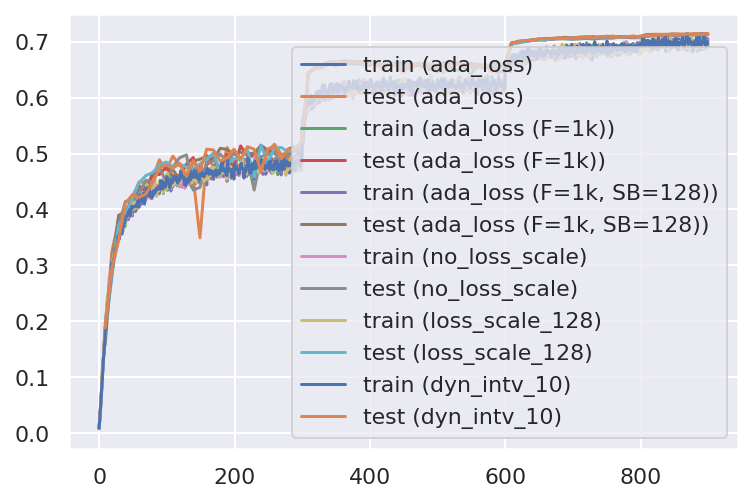

In [83]:
for label, train_dir in DIRS.items():
    gdf, sdf, ldf = utils.load_training_results(train_dir)
    print('{}: best validation accuracy={:.2f}'.format(label, ldf['validation/main/accuracy'].max() * 100))
    plt.plot(ldf['main/accuracy'], label='train ({})'.format(label))
    plt.plot(ldf[ldf['validation/main/accuracy'].notnull()]['validation/main/accuracy'], label='test ({})'.format(label))
    plt.legend()

### ResNet-50

In [78]:
DIRS = {
    'ada_loss': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/resnet50_ada_loss_16GPU.20190904',
    'ada_loss new': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/ada_loss.GPU_16.20190912',
    'ada_loss_freq_1000': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/resnet50_ada_loss_freq_1000_16GPU.20190827',
    'no_loss_scale': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/resnet50_no_loss_scale_16GPU.20190827',
    'loss_scale_128': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/resnet50_loss_scale_128_16GPU.20190827',
    'dyn (intv=10)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/dyn.GPU_16_intv_10.20190922',
}

ada_loss: best validation accuracy=76.0742
ada_loss new: best validation accuracy=75.9766
ada_loss_freq_1000: best validation accuracy=76.0742
no_loss_scale: best validation accuracy=76.0742
loss_scale_128: best validation accuracy=76.0254
dyn (intv=10): best validation accuracy=76.1230


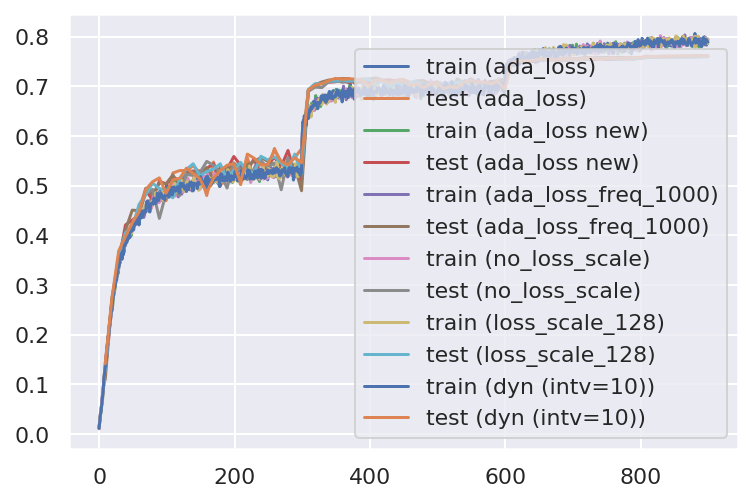

In [79]:
for label, train_dir in DIRS.items():
    gdf, sdf, ldf = utils.load_training_results(train_dir)
    print('{}: best validation accuracy={:.4f}'.format(label, ldf['validation/main/accuracy'].max() * 100))
    plt.plot(ldf['main/accuracy'], label='train ({})'.format(label))
    plt.plot(ldf[ldf['validation/main/accuracy'].notnull()]['validation/main/accuracy'], label='test ({})'.format(label))
    plt.legend()

In [31]:
DIRS = {
    'ada_loss (AB=2048)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/ada_loss.GPU_16_AB_2048',
    'ada_loss (AB=4096)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/ada_loss.GPU_16_AB_4096',
    'ada_loss (SB=128)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/ada_loss.GPU_16_SB_128',
    'ada_loss (SB=1024)': '/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/ada_loss.GPU_16_SB_1024',

}

ada_loss (AB=2048): best validation accuracy=76.0742
ada_loss (AB=4096): best validation accuracy=76.0742
ada_loss (SB=128): best validation accuracy=76.2207
ada_loss (SB=1024): best validation accuracy=75.9766


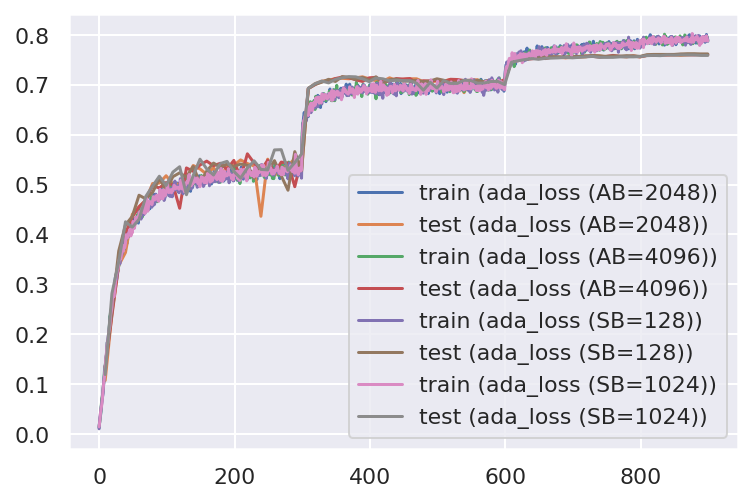

In [32]:
for label, train_dir in DIRS.items():
    gdf, sdf, ldf = utils.load_training_results(train_dir)
    print('{}: best validation accuracy={:.4f}'.format(label, ldf['validation/main/accuracy'].max() * 100))
    plt.plot(ldf['main/accuracy'], label='train ({})'.format(label))
    plt.plot(ldf[ldf['validation/main/accuracy'].notnull()]['validation/main/accuracy'], label='test ({})'.format(label))
    plt.legend()

In [54]:
gdf, sdf, ldf = utils.load_training_results('/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/ada_loss.20190809/')

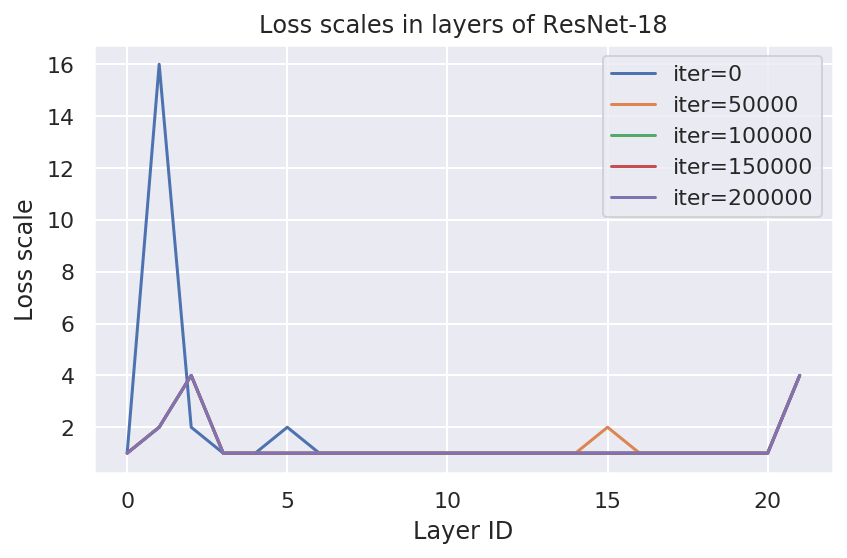

In [55]:
for it in [0, 50000, 100000, 150000, 200000]:
    scales = sdf[(sdf['key'] == 'final') & (sdf['iter'] == it)]
    plt.plot(np.arange(len(scales)), scales['val'], label='iter={}'.format(it))

plt.xlabel('Layer ID')
plt.ylabel('Loss scale')
plt.title('Loss scales in layers of ResNet-18')
plt.legend()
plt.tight_layout()
plt.savefig('ResNet-18_loss_scales.pdf')

In [57]:
gdf, sdf, ldf = utils.load_training_results('/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/loss_scale_128.20190823')

In [68]:
gdf_ = gdf[gdf['label'] == 'ReLUGrad2']
for it in [0, 50000, 100000, 150000, 200000]:
    tmp_gdf = gdf_[gdf_['iter'] == it]
    print(tmp_gdf['std'].max())

0.002085680142045021
0.02262573875486851
0.021602662280201912
0.02577921561896801
0.02601233683526516


In [69]:
gdf, sdf, ldf = utils.load_training_results('/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet18/ada_loss.20190809/')

In [70]:
gdf_ = gdf[gdf['label'] == 'ReLUGrad2']
for it in [0, 50000, 100000, 150000, 200000]:
    tmp_gdf = gdf_[gdf_['iter'] == it]
    print(tmp_gdf['std'].max())

0.000940146972425282
0.0008993850788101555
0.0010096702026203275
0.0011674531269818544
0.0011777265463024378


In [72]:
gdf, sdf, ldf = utils.load_training_results('/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/resnet50_loss_scale_128_16GPU.20190827')

In [73]:
gdf_ = gdf[gdf['label'] == 'ReLUGrad2']
for it in [0, 50000, 100000, 150000, 200000]:
    tmp_gdf = gdf_[gdf_['iter'] == it]
    print(tmp_gdf['std'].max())

0.0008162804297171532
0.014918743632733822
0.014090584591031075
0.016639923676848408
0.01895572990179062


In [74]:
gdf, sdf, ldf = utils.load_training_results('/mnt/ccnas2/bdp/rz3515/train/ada_loss/imagenet/resnet50/resnet50_ada_loss_freq_1000_16GPU.20190827')

In [75]:
gdf_ = gdf[gdf['label'] == 'ReLUGrad2']
for it in [0, 50000, 100000, 150000, 200000]:
    tmp_gdf = gdf_[gdf_['iter'] == it]
    print(tmp_gdf['std'].max())

8.659416198497638e-05
0.001719664316624403
0.0016302830772474408
0.0010237048845738173
0.0010776277631521225


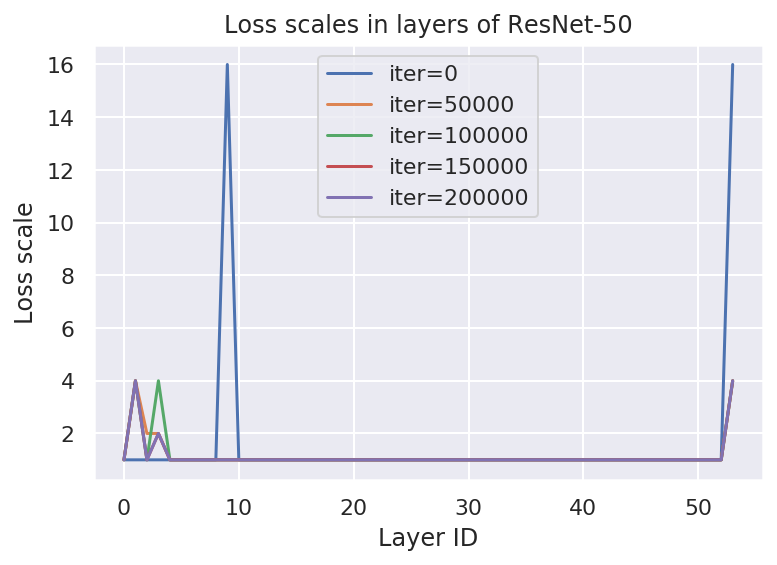

In [51]:
for it in [0, 50000, 100000, 150000, 200000]:
    scales = sdf[(sdf['key'] == 'final') & (sdf['iter'] == it)]
    plt.plot(np.arange(len(scales)), scales['val'], label='iter={}'.format(it))

plt.xlabel('Layer ID')
plt.ylabel('Loss scale')
plt.title('Loss scales in layers of ResNet-50')
plt.legend()